# Triangular_fuzzy_number_generate_BPA

## Import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt 

In [2]:
# 1. 加载Iris数据集并划分为训练集和测试集
iris = load_iris()
X = iris.data  # 四个属性
y = iris.target  # 三个类 (0, 1, 2)
num_classes = len(np.unique(iris.target))
num_attributes = iris.data.shape[1]
# 将数据集划分为训练集和测试集，乱序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Get mean and std

In [3]:
# 2. 计算每个类中每个属性的 mean value and standard deviation (无偏估计)

def calculate_mean_std_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

def calculate_mean_std_min_max_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1), np.min(X_class[:, i]), np.max(X_class[:, i])) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)
print("每个类中每个属性的均值，标准差，最小值，最大值:\n", mean_std_min_max_by_class)
print("Shape of mean_std_by_class:\n", mean_std_min_max_by_class.shape)

每个类中每个属性的均值，标准差，最小值，最大值:
 [[[4.98461538 0.38150565 4.3        5.8       ]
  [3.44871795 0.40449565 2.3        4.4       ]
  [1.45128205 0.17899102 1.         1.9       ]
  [0.25897436 0.11405896 0.1        0.6       ]]

 [[6.02105263 0.47257655 5.         7.        ]
  [2.8        0.29954921 2.2        3.4       ]
  [4.29736842 0.40768751 3.3        5.        ]
  [1.32631579 0.19684568 1.         1.8       ]]

 [[6.57906977 0.67101847 4.9        7.9       ]
  [2.95116279 0.32759738 2.2        3.8       ]
  [5.55813953 0.57579451 4.5        6.9       ]
  [1.99534884 0.2672198  1.4        2.5       ]]]
Shape of mean_std_by_class:
 (3, 4, 4)


In [4]:
p = 0.4

In [5]:
def get_triangular_membership_functions(mean, std, min_val, max_val, p=0.4):

    u = max_val + p * std  
    l = min_val - p * std  

    def triangular_membership_function(x):
        if x < l:
            return 0  
        elif x > u:
            return 0  
        elif l <= x <= mean:
            return (x - l) / (mean - l)
        elif mean < x <= u:
            return (u - x) / (u - mean)
        else:
            return 0  
    return triangular_membership_function

In [6]:
def get_triangular_membership_functions_list(mean_std_by_class):
    triangular_membership_functions_by_class = []
    for class_data in mean_std_by_class:
        class_functions = []
        for attr_data in class_data:
            mean, std, min_val, max_val = attr_data
            membership_function = get_triangular_membership_functions(mean, std, min_val, max_val)
            class_functions.append(membership_function)
        triangular_membership_functions_by_class.append(class_functions)
    return np.array(triangular_membership_functions_by_class)

triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max_by_class)
triangular_membership_functions_by_class.shape

(3, 4)

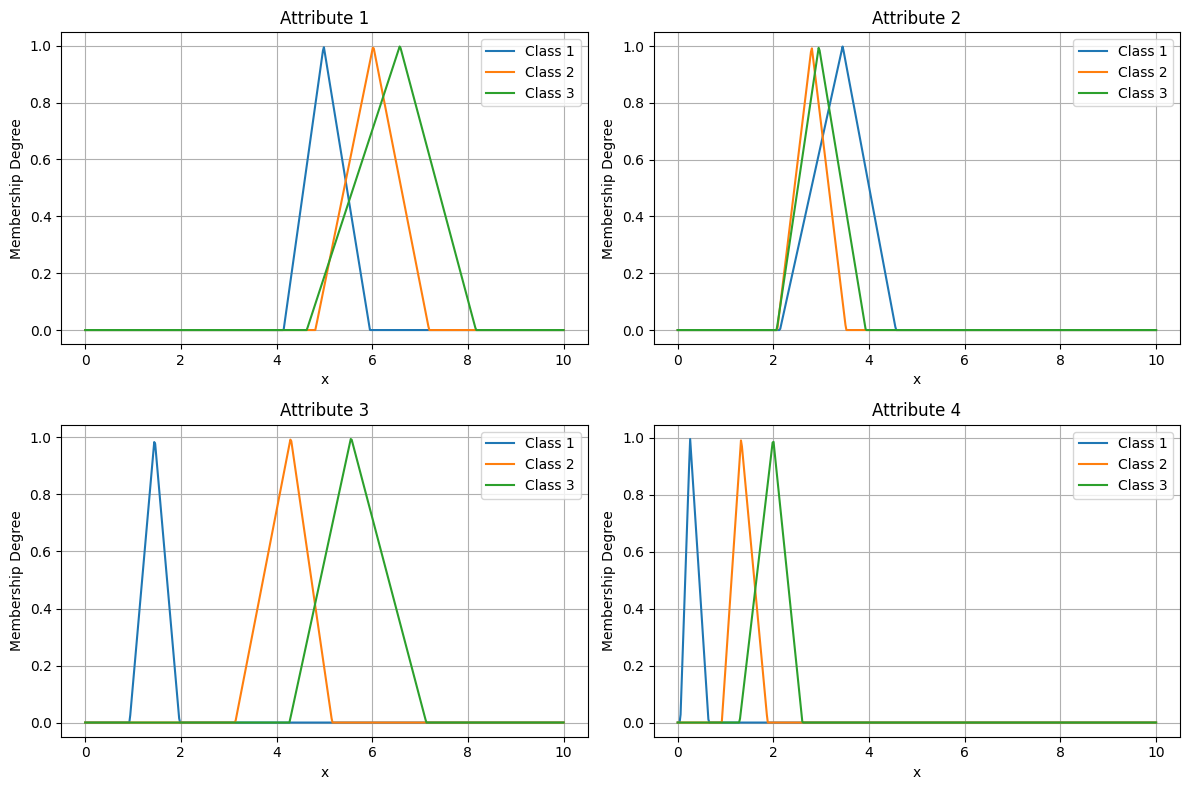

In [7]:
def plot_triangular_membership_functions(triangular_membership_functions_by_class):
    num_classes, num_attributes = triangular_membership_functions_by_class.shape
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # Assuming a reasonable range for x (e.g., [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # Two plots per row
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_triangular_membership_functions(triangular_membership_functions_by_class)

In [8]:
sample = np.random.randint(0, len(X_test))
test_sample = (X_test[sample], y_test[sample])
test_sample

(array([5. , 2. , 3.5, 1. ]), 1)

In [9]:
def calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class):

    # test_values, true_class = test_sample  # 获取属性值和真实类别
    test_values = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # 初始化一个存储隶属度值的列表
    membership_values = []
    
    for class_idx in range(num_classes):
        class_membership_values = []
        for attr_idx in range(num_attributes):
            # 获取对应类和属性的三角隶属函数
            membership_function = triangular_membership_functions_by_class[class_idx][attr_idx]
            # 计算该属性值的隶属度
            membership_value = membership_function(test_values[attr_idx])
            class_membership_values.append(membership_value)
        membership_values.append(class_membership_values)
    
    return np.array(membership_values)


# Calculate the membership values for the test sample
membership_values = calculate_membership_for_sample(test_sample[0], triangular_membership_functions_by_class)

membership_values  # This will output the membership values for each class and attribute


array([[0.98410659, 0.        , 0.        , 0.        ],
       [0.1562129 , 0.        , 0.31287609, 0.19438954],
       [0.18917161, 0.        , 0.        , 0.        ]])

In [10]:
def plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample):
    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # 假设x的合理范围 (例如 [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # 两个图每行
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # 绘制测试样本的隶属度点
        for class_index in range(num_classes):
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            test_value = test_values[attr_index]  # 获取测试样本的属性值
            test_membership_value = membership_function(test_value)  # 计算测试样本的隶属度
            # 在图上标记测试样本的隶属度值
            ax.plot(test_value, test_membership_value, 'ro')  # 红点表示测试样本值
            ax.text(test_value, test_membership_value, f'{test_membership_value:.2f}', fontsize=12, color='red')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

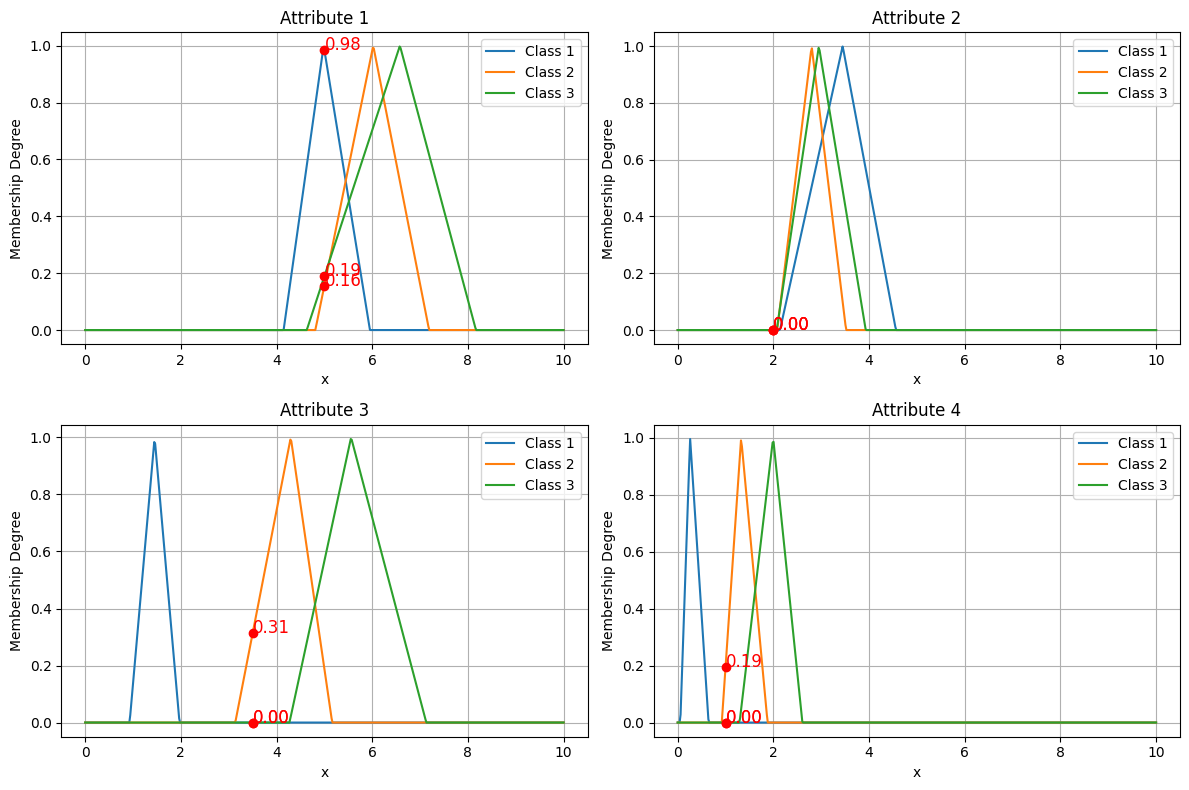

In [11]:
plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample)

In [12]:
def sort_membership(membership_values):
    sorted_indices = np.argsort(-membership_values, axis=0)  # 降序排序，使用负号实现降序
    sorted_mv = np.take_along_axis(membership_values, sorted_indices, axis=0)  # 按照索引排序后的值
    return sorted_indices, sorted_mv

In [13]:
sorted_indices, sorted_mv = sort_membership(membership_values)

In [14]:
print("\nsorted_indices\n", sorted_indices)
print("\nsorted_mv\n", sorted_mv)


sorted_indices
 [[0 0 1 1]
 [2 1 0 0]
 [1 2 2 2]]

sorted_mv
 [[0.98410659 0.         0.31287609 0.19438954]
 [0.18917161 0.         0.         0.        ]
 [0.1562129  0.         0.         0.        ]]


In [15]:
def process_sorted_mv(sorted_mv):
    eps = 0.0001
    sorted_mv = sorted_mv + eps
    
    col_sum = np.sum(sorted_mv, axis=0)

    num_classes, num_attributes = sorted_mv.shape
    result = np.zeros((num_classes, num_attributes))
    
    result[:num_classes, :] = sorted_mv
    
    for i in range(num_attributes): 
        result[:num_classes, i] = sorted_mv[:, i] / col_sum[i] 
    
    return result

In [16]:
normalized_sorted_mv = process_sorted_mv(sorted_mv)
normalized_sorted_mv

array([[7.40121202e-01, 3.33333333e-01, 9.99361382e-01, 9.98972723e-01],
       [1.42331836e-01, 3.33333333e-01, 3.19309177e-04, 5.13638281e-04],
       [1.17546962e-01, 3.33333333e-01, 3.19309177e-04, 5.13638281e-04]])

In [17]:
np.sum(normalized_sorted_mv, axis=0)

array([1., 1., 1., 1.])

In [18]:
print("\nsorted_indices\n", sorted_indices)


sorted_indices
 [[0 0 1 1]
 [2 1 0 0]
 [1 2 2 2]]


In [19]:
def generate_bpa(normalized_sorted_mv, sorted_indices):
    dict_list = []

    num_FOD, num_attribute = normalized_sorted_mv.shape

    for i in range(num_attribute):
        dict_i = {}
        for j in range(num_FOD):
            A = tuple(sorted_indices[:j + 1, i])
            MA = normalized_sorted_mv[j, i]
            dict_i[A] = MA
        dict_list.append(dict_i)
            
    return dict_list

In [20]:
bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
bpa_results

[{(0,): 0.7401212019361605,
  (0, 2): 0.14233183604903096,
  (0, 2, 1): 0.11754696201480853},
 {(0,): 0.3333333333333333,
  (0, 1): 0.3333333333333333,
  (0, 1, 2): 0.3333333333333333},
 {(1,): 0.9993613816463841,
  (1, 0): 0.00031930917680797634,
  (1, 0, 2): 0.00031930917680797634},
 {(1,): 0.9989727234376262,
  (1, 0): 0.0005136382811869194,
  (1, 0, 2): 0.0005136382811869194}]

In [21]:
default_fusion_order = [i for i in range(num_attributes)]
default_reliability_vector = [(1 - 0.5 * i / (num_attributes - 1)) for i in range(num_attributes)]
# default_reliability_vector = [(1 - i / (12)) for i in range(num_attributes)]
print("Default fusion order: ", default_fusion_order)
print("Default reliability vector: ", default_reliability_vector)

Default fusion order:  [0, 1, 2, 3]
Default reliability vector:  [1.0, 0.8333333333333334, 0.6666666666666667, 0.5]


In [22]:
def shuffle_by_defusion_order(data, order):
    reordered_data = [data[i] for i in order]
    return reordered_data

shuffled_bpa_results = shuffle_by_defusion_order(bpa_results, [0, 1, 2, 3])
shuffled_bpa_results

[{(0,): 0.7401212019361605,
  (0, 2): 0.14233183604903096,
  (0, 2, 1): 0.11754696201480853},
 {(0,): 0.3333333333333333,
  (0, 1): 0.3333333333333333,
  (0, 1, 2): 0.3333333333333333},
 {(1,): 0.9993613816463841,
  (1, 0): 0.00031930917680797634,
  (1, 0, 2): 0.00031930917680797634},
 {(1,): 0.9989727234376262,
  (1, 0): 0.0005136382811869194,
  (1, 0, 2): 0.0005136382811869194}]

In [23]:
def generate_all_orderings(num):
    result = []
    
    # Iterate over lengths from 1 to 3 (based on the provided examples)
    for length in range(1, 4):
        # Generate all permutations of the set {0, 1, 2} of the given length
        for perm in itertools.permutations(range(num), length):
            result.append(perm)
    
    return result

# Get the result
orderings = generate_all_orderings(3)

orderings


[(0,),
 (1,),
 (2,),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (0, 1, 2),
 (0, 2, 1),
 (1, 0, 2),
 (1, 2, 0),
 (2, 0, 1),
 (2, 1, 0)]

In [24]:
def F_RPS_reliability(x):
    result = 0
    for k in range(x + 1):
        result += math.factorial(x) / math.factorial(x - k)
    return result


def get_PMF_with_reliability(RPS_wv, reliability_vector, num_classes):
    RPS_wv_r = []

    for v, RPS_wv_j in enumerate(RPS_wv):
        RPS_wv_r_j = dict()
        
        r_v = reliability_vector[v]

        for A_tuple in generate_all_orderings(num_classes):
            MA = 0
            
            if A_tuple in RPS_wv_j:
                MA = RPS_wv_j[A_tuple]
            
            if len(A_tuple) == 1:
                MA_r = MA * r_v
            elif len(A_tuple) != 1:
                MA_r = MA * r_v + ((1 - r_v) / (F_RPS_reliability(num_classes) - num_classes - 1))
                
            #RPS_wv_r_j.add((A_tuple, MA_r))
            RPS_wv_r_j[A_tuple] = MA_r

        RPS_wv_r.append(RPS_wv_r_j)
        
    return RPS_wv_r



In [25]:
PMF_with_reliability = get_PMF_with_reliability(shuffled_bpa_results, default_reliability_vector, num_classes)
PMF_with_reliability

[{(0,): 0.7401212019361605,
  (1,): 0.0,
  (2,): 0.0,
  (0, 1): 0.0,
  (0, 2): 0.14233183604903096,
  (1, 0): 0.0,
  (1, 2): 0.0,
  (2, 0): 0.0,
  (2, 1): 0.0,
  (0, 1, 2): 0.0,
  (0, 2, 1): 0.11754696201480853,
  (1, 0, 2): 0.0,
  (1, 2, 0): 0.0,
  (2, 0, 1): 0.0,
  (2, 1, 0): 0.0},
 {(0,): 0.2777777777777778,
  (1,): 0.0,
  (2,): 0.0,
  (0, 1): 0.2916666666666667,
  (0, 2): 0.013888888888888886,
  (1, 0): 0.013888888888888886,
  (1, 2): 0.013888888888888886,
  (2, 0): 0.013888888888888886,
  (2, 1): 0.013888888888888886,
  (0, 1, 2): 0.2916666666666667,
  (0, 2, 1): 0.013888888888888886,
  (1, 0, 2): 0.013888888888888886,
  (1, 2, 0): 0.013888888888888886,
  (2, 0, 1): 0.013888888888888886,
  (2, 1, 0): 0.013888888888888886},
 {(0,): 0.0,
  (1,): 0.6662409210975895,
  (2,): 0.0,
  (0, 1): 0.027777777777777773,
  (0, 2): 0.027777777777777773,
  (1, 0): 0.027990650562316425,
  (1, 2): 0.027777777777777773,
  (2, 0): 0.027777777777777773,
  (2, 1): 0.027777777777777773,
  (0, 1, 2): 0.0

In [26]:
def right_intersection(A, B):
    """
    右正交 (RI)，即 B 中去除不在 A 中的元素
    """
    return tuple(item for item in B if item in A)


def left_intersection(A, B):
    """
    左正交 (LI)，即 A 中去除不在 B 中的元素
    """
    return tuple(item for item in A if item in B)


def calculate_KR(M1, M2):
    """
    计算右正交和的 K^R (K_R)
    """
    K_R = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if right_intersection(B, C) == ():
                K_R += w1 * w2
    return K_R


def calculate_KL(M1, M2):
    """
    计算左正交和的 K^L (K_L)
    """
    K_L = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if left_intersection(B, C) == ():
                K_L += w1 * w2
    return K_L


def ROS(M1, M2, num_classes):
    """
    右正交和 (ROS)
    """
    K_R = calculate_KR(M1, M2)
    result = dict()

    if K_R != 1:  # 防止 K_R 为 1 时出现除以 0 的情况
        #for A, w1 in M1.items():
        for A in generate_all_orderings(num_classes):
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if right_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_R)) * weight_sum            
    return result


def LOS(M1, M2, num_classes):
    """
    左正交和 (LOS)
    """
    K_L = calculate_KL(M1, M2)
    result = dict()

    if K_L != 1:  # 防止 K_L 为 1 时出现除以 0 的情况
        #for A, w1 in M1.items():
        for A in generate_all_orderings(num_classes):
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if left_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_L)) * weight_sum
    return result



# 连续右正交和
def continuous_right_orthogonal_sum(PMFs, num_classes):
    """
    连续执行右正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的右正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = ROS(result, PMFs[i], num_classes)
    return result

# 连续左正交和
def continuous_left_orthogonal_sum(PMFs, num_classes):
    """
    连续执行左正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的左正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = LOS(result, PMFs[i], num_classes)
    return result

In [27]:
pmf = continuous_left_orthogonal_sum(PMF_with_reliability, num_classes)
pmf

{(0,): 0.5592373303783186,
 (1,): 0.34909553260912346,
 (2,): 0.018947431783421204,
 (0, 1): 0.022373438426129558,
 (0, 2): 0.03161785023379557,
 (2, 1): 0.008940531561353098,
 (0, 2, 1): 0.009787885007860772}

In [28]:
def calculate_OPT(pmf_data, num_classes):
    # 初始化 P_OPT, 每个类的初始概率为0
    P_OPT = {i: 0 for i in range(num_classes)}
    
    # 遍历 PMF 数据，处理每个排列事件
    for A, mass in pmf_data.items():
        if len(A) == 1:
            # 单元素事件，直接加到对应的 P_OPT 中
            theta = A[0]
            P_OPT[theta] += mass
        else:
            # 多元素事件
            last_element = A[-1]
            for theta in A:
                if theta != last_element:
                    P_OPT[theta] += mass / (len(A) - 1)
    
    return P_OPT

In [29]:
calculate_OPT(pmf, num_classes)

{0: 0.6181225615421742, 1: 0.34909553260912346, 2: 0.03278190584870469}

In [30]:
def classify_once(x, 
                  num_classes,
                  mean_std_min_max, 
                  default_fusion_order, 
                  default_reliability_vector):

    triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max)
    membership_values = calculate_membership_for_sample(x, triangular_membership_functions_by_class)
    sorted_indices, sorted_mv = sort_membership(membership_values)
    normalized_sorted_mv = process_sorted_mv(sorted_mv)
    bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
    
    shuffled_bpa_results = shuffle_by_defusion_order(bpa_results, default_fusion_order)
    PMF_with_reliability = get_PMF_with_reliability(shuffled_bpa_results, default_reliability_vector, num_classes)
    
    pmf = continuous_left_orthogonal_sum(PMF_with_reliability, num_classes)
    opt_dict = calculate_OPT(pmf, num_classes)
    return max(opt_dict, key=opt_dict.get)

In [31]:
sample1 = np.random.randint(0, len(X_test))
test_sample1 = (X_test[sample], y_test[sample])
test_sample1

(array([5. , 2. , 3.5, 1. ]), 1)

In [32]:
def test_acc(iris):
    X = iris.data  # 四个属性
    y = iris.target  # 三个类 (0, 1, 2)
    num_classes = len(np.unique(iris.target))
    num_attributes = iris.data.shape[1]
    
    default_fusion_order = [i for i in range(num_attributes)]
    default_reliability_vector = [(1 - 0.5 * i / (num_attributes - 1)) for i in range(num_attributes)]
    # 将数据集划分为训练集和测试集，乱序
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)

    correct_predictions = 0
    total_samples = len(X_test)

    for test_sample, true_label in zip(X_test, y_test):
        predicted_label = classify_once(test_sample, 
                                        num_classes, 
                                        mean_std_min_max_by_class, 
                                        default_fusion_order, 
                                        default_reliability_vector)
        
        if predicted_label == true_label:
            correct_predictions += 1

    # 计算准确率
    accuracy = correct_predictions / total_samples
    return accuracy
    

In [33]:
iris = load_iris()
test_acc(iris)

0.9

In [34]:
def analyze_accuracy(iris, times=100):
    accuracies = []

    # 进行10次测试
    for _ in range(times):
        acc = test_acc(iris)  
        accuracies.append(acc)

    # 统计分析
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    # print(f"{times}次测试的准确率分别是: ")
    # for i in accuracies:
    #     print(i)
    print(f"平均准确率: {mean_acc:.4f}")
    print(f"准确率标准差: {std_acc:.4f}")
    

In [35]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_diabetes, load_digits

wine = load_wine()
breast_cancer = load_breast_cancer()
diabetes = load_diabetes()
digits = load_digits()
iris = load_iris()

In [36]:
test_acc(wine)

0.8611111111111112

In [37]:
test_acc(breast_cancer)

0.8859649122807017

In [39]:
analyze_accuracy(wine)

平均准确率: 0.8553
准确率标准差: 0.0529


In [41]:
analyze_accuracy(breast_cancer)

平均准确率: 0.9287
准确率标准差: 0.0205


In [42]:
analyze_accuracy(iris)

平均准确率: 0.8887
准确率标准差: 0.0532
